In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer
from oma_tracking.data.make_dataset import get_mpe_data
from oma_tracking.data.utils import read_simulations_csv_files


In [3]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,5,4,tzinfo=utc)
end_date = datetime.datetime(2023,5,4,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'
home_folder = "../../../"
data_path = home_folder + "data/nw2/raw/" + location + "_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
weather_data_path = home_folder + "data/nw2/mvbc_data.parquet"
tracked_frequencies_path = home_folder + "data/nw2/tracked_modes/harmonics_removed/" + location + ".parquet"
simulations_data_path = home_folder + "data/nw2/simulations/" + location + "/"

turbine_data = pd.read_parquet(data_path).loc[:end_date]
turbine_data = turbine_data.loc[~turbine_data.index.duplicated(keep='first')]
weather_station_data_LAT = pd.read_parquet(weather_data_path).loc[:end_date]


# Get all the data
data = pd.read_parquet(data_path).loc[:end_date]
mvbc_data = pd.read_parquet(weather_data_path).loc[:end_date]
tracked_frequencies = pd.read_parquet(tracked_frequencies_path).loc[:end_date]
simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)


name_location = 'NW2_D01'
mpe_data = {}
directions = ['SS', 'FA']
for direction in directions:
    mpe_data[direction] = get_mpe_data(turbine_data, direction, name_location)

In [56]:
1 - weather_station_data_LAT.isna().sum()/len(weather_station_data_LAT)

mvbc_WandelaarBuoy_10%_highest_waves                                    1.000000
mvbc_WandelaarBuoy_Wave_height                                          1.000000
mvbc_WandelaarBuoy_Average_wave_period                                  1.000000
mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s                      1.000000
mvbc_WandelaarBuoy_Sea_water_temperature                                0.876167
mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)    0.999935
mvbc_WandelaarMeasuringpile_Average_wind_direction                      1.000000
mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)         0.999935
mvbc_WandelaarMeasuringpile_Tide_TAW                                    1.000000
mvbc_WandelaarMeasuringpile_Relative_humidity                           0.572042
mvbc_WandelaarMeasuringpile_Air_pressure                                0.999289
mvbc_WandelaarMeasuringpile_Air_temperature                             1.000000
dtype: float64

In [55]:
1 - turbine_data.isna().sum()/len(turbine_data)

location                      1.000000
mean_NW2_D01_rpm              0.968562
mean_NW2_D01_yaw              0.968562
std_NW2_D01_pitch             0.973016
mean_NW2_D01_pitch            0.968562
mean_NW2_D01_power            0.968562
std_NW2_D01_towerxacc         0.435634
std_NW2_D01_toweryacc         0.435634
std_NW2_D01_windspeed         0.968562
mean_NW2_D01_towerxacc        0.435634
mean_NW2_D01_toweryacc        0.435634
mean_NW2_D01_windspeed        0.968562
mean_NW2_D01_winddirection    0.968562
mpe_NW2_D01_FA                1.000000
mpe_NW2_D01_SS                1.000000
mpe_NW2_D01_SS1               0.987395
max_NW2_D01_NAC_ACC_Z         1.000000
min_NW2_D01_NAC_ACC_Z         1.000000
rms_NW2_D01_NAC_ACC_Z         1.000000
std_NW2_D01_NAC_ACC_Z         1.000000
max_NW2_D01_NAC_ACC_FA        1.000000
max_NW2_D01_NAC_ACC_SS        1.000000
mean_NW2_D01_NAC_ACC_Z        1.000000
min_NW2_D01_NAC_ACC_FA        1.000000
min_NW2_D01_NAC_ACC_SS        1.000000
rms_NW2_D01_NAC_ACC_FA   

mean_NW2_D01_rpm    10.445
dtype: float64


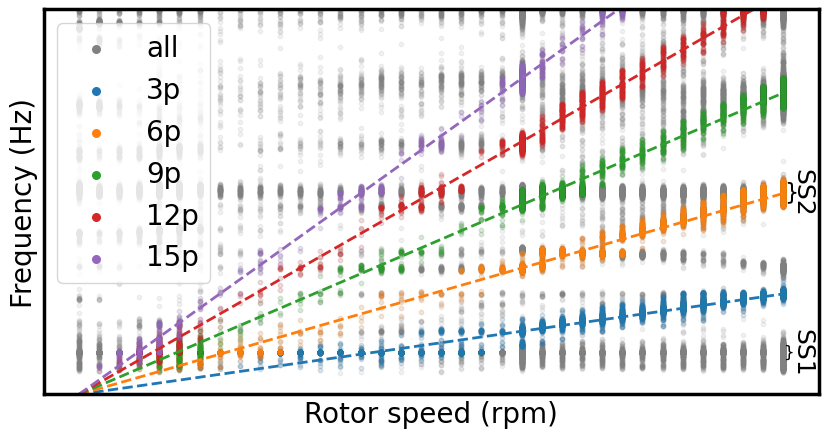

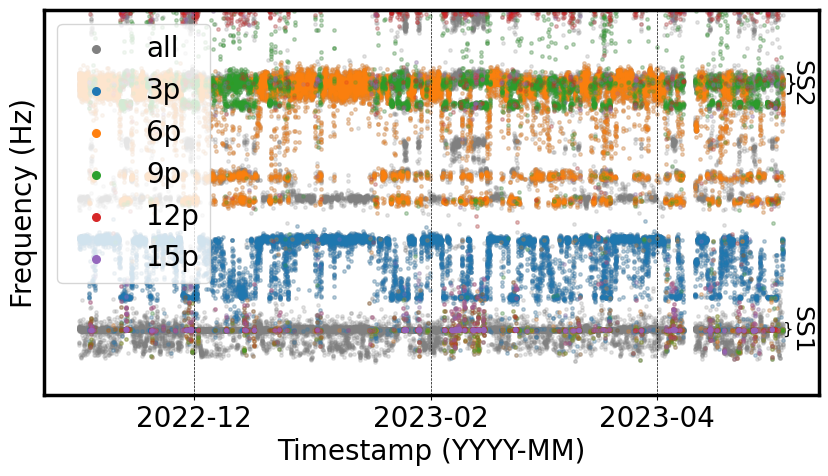

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


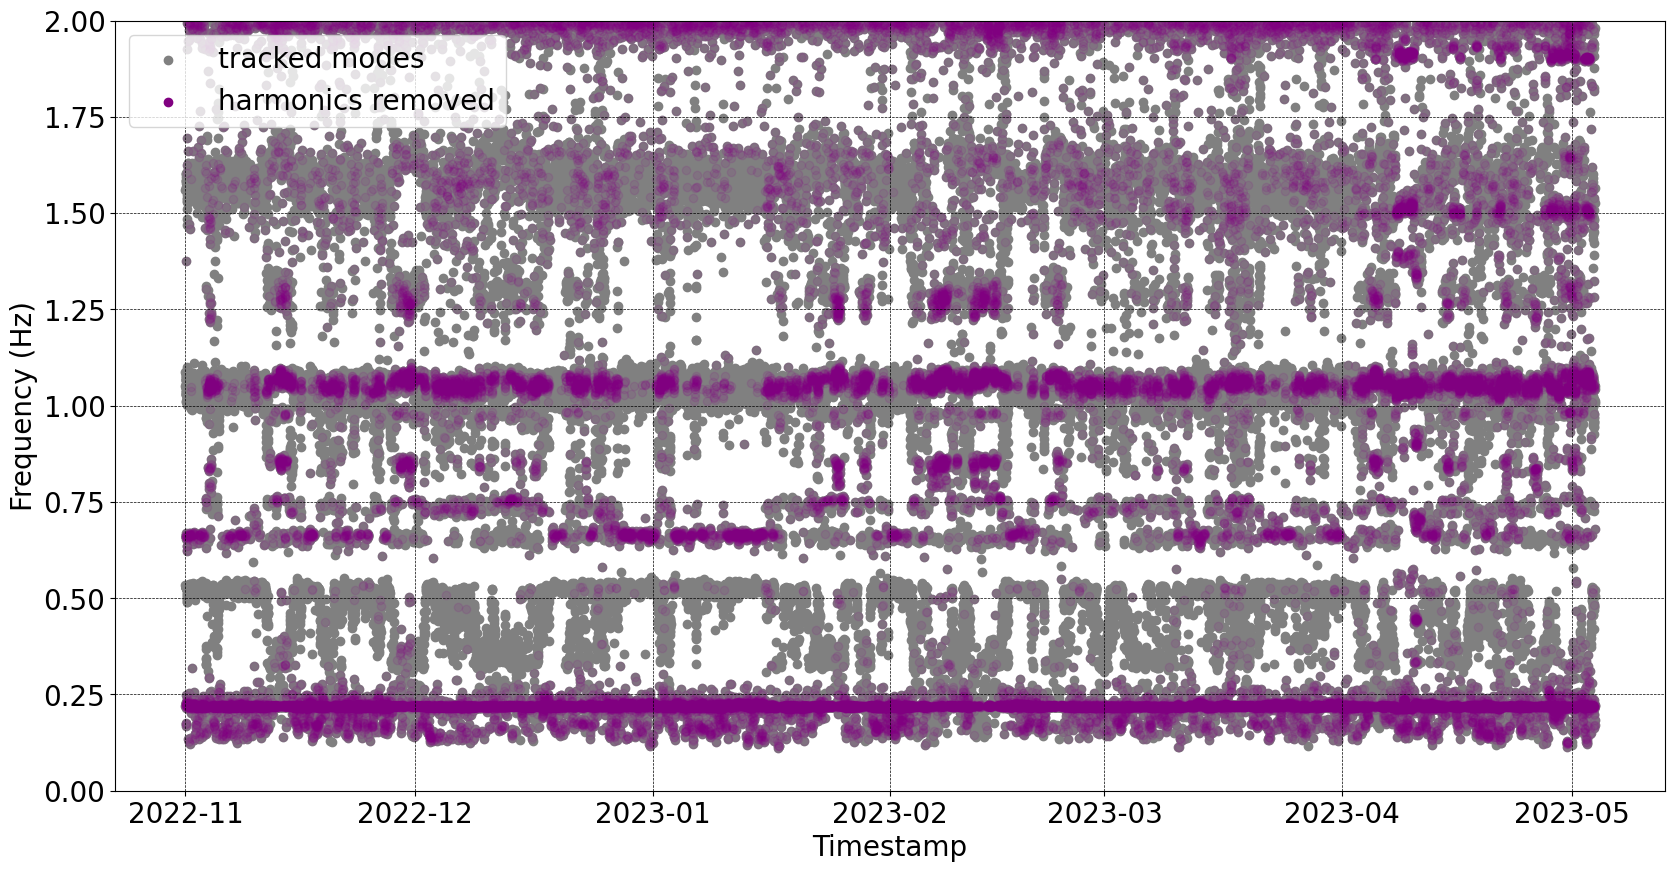

In [23]:
from oma_tracking.modal_tracking.harmonics import HarmonicDetector
plt.rcParams.update({'font.size': 20})
clustering_data = {}
harmonic_detectors = {}
harmonics_removed = {}
for direction in ['SS']:
    clustering_data[direction] = mpe_data[direction].rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
    harmonic_detectors[direction] = HarmonicDetector(turbine_data, clustering_data[direction], min_rpm=0, max_distance = 0.08, p_orders=[3,6,9,12, 15])
    distance_calculator_data = harmonic_detectors[direction].get_distance_calculator_data()
    harmonic_detectors[direction].plot_distances()
    harmonic_detectors[direction].plot_harmonics_removed()
    harmonics_removed[direction] = harmonic_detectors[direction].remove_harmonics()


C:\Users\Max\AppData\Local\Temp\ipykernel_20660\2541408858.py:40: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


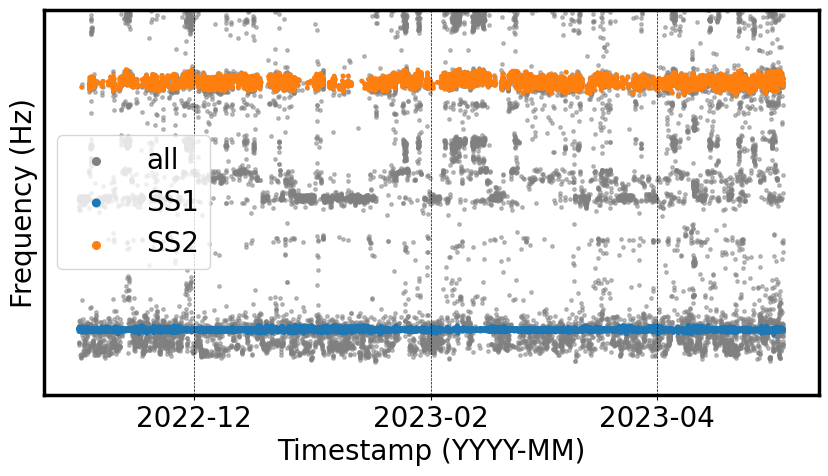

In [52]:
direction = 'SS'
mc = {}
clustered_modes = {}
plt.rcParams.update({'font.size': 20})  # Set the font size to 12
import matplotlib.dates as mdates


mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 20,
    multipliers = {"frequency": 500, "size": 2, "damping": 5},
    index_divider = 2000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = harmonics_removed[direction]
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=5000)

plt.figure(figsize=(10,5))

plt.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey', s=6)

tab10 = plt.get_cmap('tab10')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = plt.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap, s=6)
plt.scatter([], [], c='#FF800E', s=6)
legend = plt.legend(['all', 'SS1', 'SS2'], fontsize = 20)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)

plt.xlabel('Timestamp (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
#plt.title('Tracked physical modes in the SS direction', fontsize=30)
plt.ylim(0, 1.3)
plt.yticks([])

for handle in legend.legendHandles:
    handle.set_alpha(1.0)
    handle.set_sizes([30.0])

# Get the current axes
ax = plt.gca()

# Increase the width of the spines
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['top'].set_linewidth(2.5)

# Adjust the x-axis tick frequency
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.show()

SS1_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 0]
SS1_harmonics_removed = SS1_harmonics_removed[~SS1_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)
SS2_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 1]
SS2_harmonics_removed = SS2_harmonics_removed[~SS2_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

In [46]:
print("% tracking SS1 = ", len(SS1_harmonics_removed.dropna())/len(SS1_harmonics_removed))
print("% tracking SS2 = ", len(SS2_harmonics_removed.dropna())/len(SS2_harmonics_removed))

% tracking SS1 =  0.8064466791572669
% tracking SS2 =  0.24475203609528542


c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


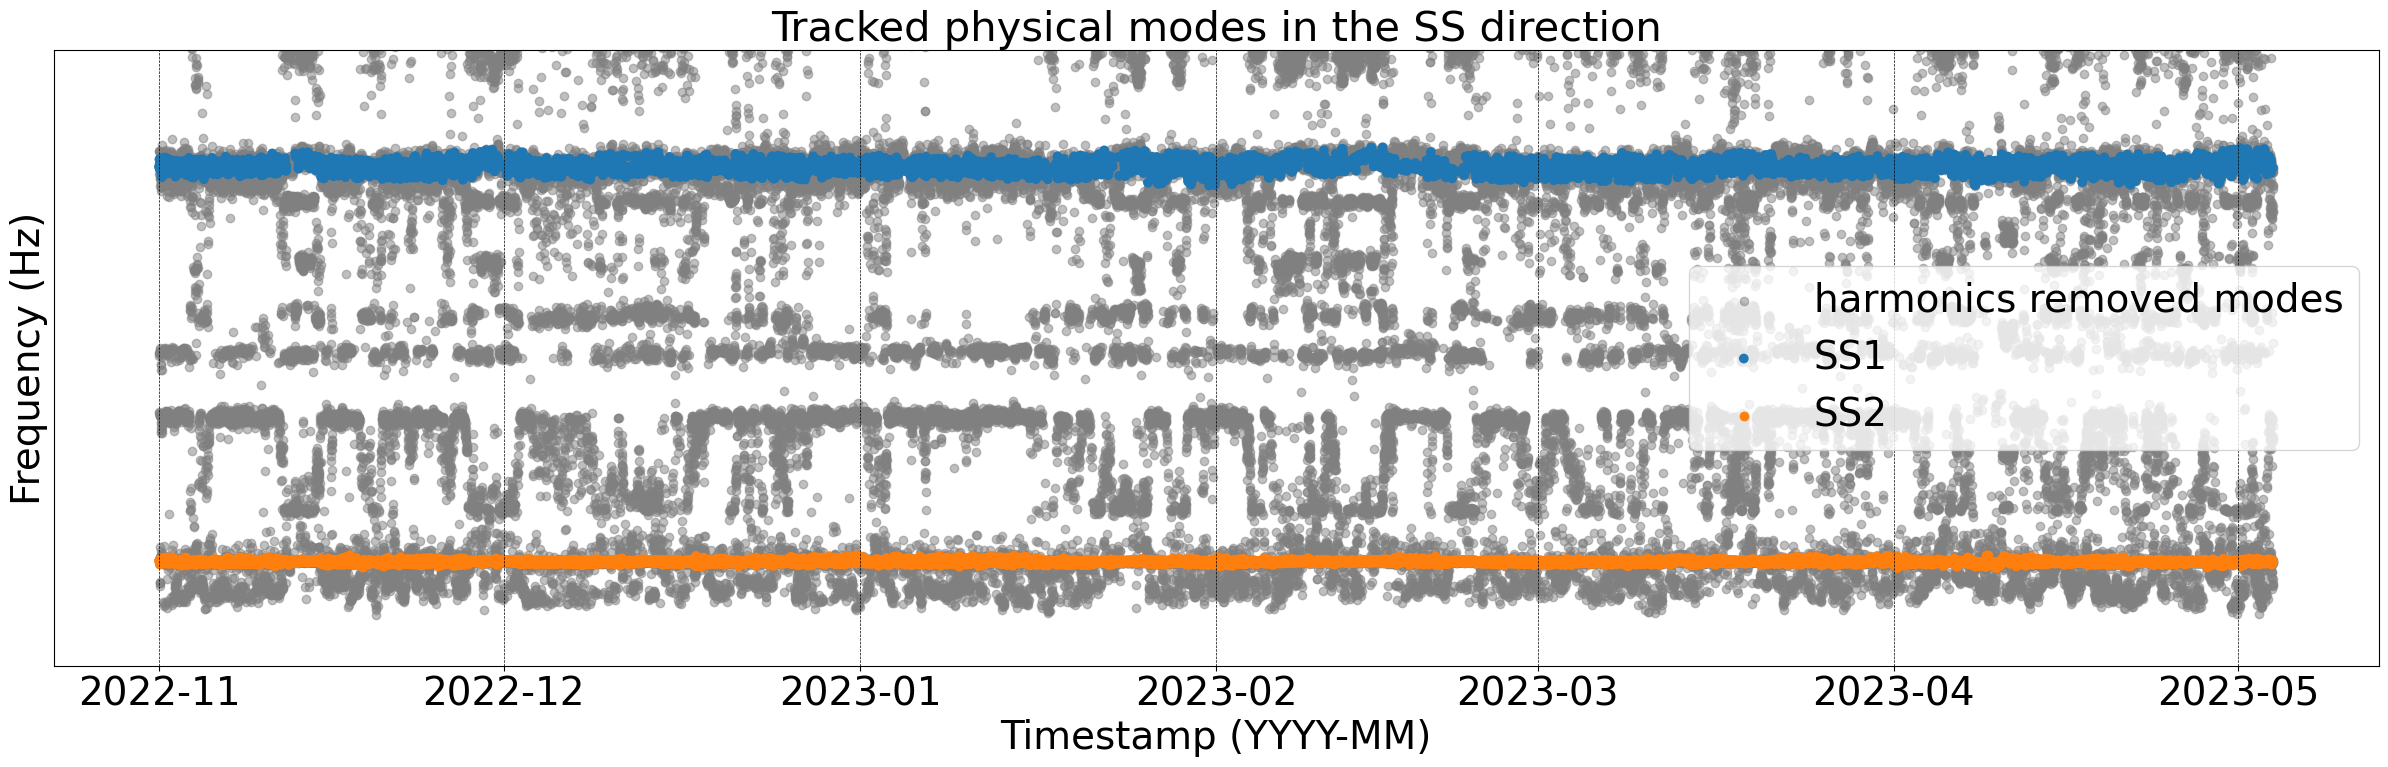

In [44]:
direction = 'SS'
mc = {}
clustered_modes = {}
plt.rcParams.update({'font.size': 28})  # Set the font size to 12


mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 20,
    multipliers = {"frequency": 500, "size": 2, "damping": 5},
    index_divider = 2000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = mpe_data[direction].rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=5000)

plt.figure(figsize=(30,8))

plt.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab10')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = plt.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap)
plt.scatter([], [], c='#FF800E')
plt.legend(['harmonics removed modes', 'SS1', 'SS2'])
plt.grid(True, color='k', linestyle='--', linewidth=0.5)

plt.xlabel('Timestamp (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked physical modes in the SS direction', fontsize=30)
plt.ylim(0, 1.3)
plt.yticks([])

plt.show()

SS1_ = clustered_modes[direction][clustered_modes[direction].labels == 1]
SS1_ = SS1_[~SS1_.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)
SS2_ = clustered_modes[direction][clustered_modes[direction].labels == 0]
SS2_ = SS2_[~SS2_.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

In [47]:
print("% tracking SS1 = ", len(SS1_harmonics_removed.dropna())/len(SS1_harmonics_removed))
print("% tracking SS2 = ", len(SS2_harmonics_removed.dropna())/len(SS2_harmonics_removed))

% tracking SS1 =  0.8064466791572669
% tracking SS2 =  0.24475203609528542


In [48]:
print("% harmonics SS1 = ", len(SS1_harmonics_removed.dropna())/len(SS1_.dropna()))
print("% harmonics SS2 = ", len(SS2_harmonics_removed.dropna())/len(SS2_.dropna()))


% harmonics SS1 =  0.9273214913823425
% harmonics SS2 =  0.45882015626119993
